In [1]:
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model

import pandas as pd
import numpy as np
import random
import scipy.misc
from google.colab import drive 

import seaborn as sns
import librosa
import librosa.display
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from google.colab import drive 



from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
tf.random.set_seed(12345)
np.random.seed(12345)
import pickle
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DRIVE_FOLDER = '/content/drive/My Drive/data/false/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
false_dict = {'name':[]}
for file in entries:

    false_dict['name'].append(file)
DRIVE_FOLDER = '/content/drive/My Drive/data/true/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
true_dict = {'name':[]}
for file in entries:

    true_dict['name'].append(file)

In [3]:
df1 = pd.DataFrame(false_dict)
df1['label'] = 0
df1['path'] = '/content/drive/My Drive/data/false/'
print('The number of false labels is: ', df1.shape[0])
df2 = pd.DataFrame(true_dict)
df2['label'] = 1
df2['path'] = '/content/drive/My Drive/data/true/'
print('The number of true labels is: ', df2.shape[0])
# combine both dataframes
df = pd.concat([df1,df2])
df = df.sample(frac=1, random_state=56).reset_index(drop=True)

print('The length of the dataset is: ', f'{df.shape[0]:,}')

labels = df['label'].unique()
df.head

The number of false labels is:  791
The number of true labels is:  776
The length of the dataset is:  1,567


<bound method NDFrame.head of                        name  label                                 path
0         Mani_false523.wav      0  /content/drive/My Drive/data/false/
1           Maninoise88.wav      1   /content/drive/My Drive/data/true/
2         Mani_false821.wav      0  /content/drive/My Drive/data/false/
3     Mani_false126 (1).wav      0  /content/drive/My Drive/data/false/
4         Mani_false366.wav      0  /content/drive/My Drive/data/false/
...                     ...    ...                                  ...
1562            Mani877.wav      1   /content/drive/My Drive/data/true/
1563            Mani291.wav      1   /content/drive/My Drive/data/true/
1564            Mani834.wav      1   /content/drive/My Drive/data/true/
1565      Mani_false590.wav      0  /content/drive/My Drive/data/false/
1566      Mani_false868.wav      0  /content/drive/My Drive/data/false/

[1567 rows x 3 columns]>

In [4]:
h = 400
w = 400
n_mfccs = 128


In [5]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [6]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    if xx < array.shape[0]:
      xx = array.shape[0]
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [7]:
def generate_features(y_cut, sr):
   
    stft = scale_minmax(np.abs(librosa.stft(y_cut)),0,255)
    stft = stft[0:h,0:w]
   
    stft = padding(stft, h,w)

    mfccs = scale_minmax(np.abs(librosa.feature.mfcc(y_cut, n_mfcc= n_mfccs)),0,255)
    mfccs = mfccs[0:h, 0:w]
    mfccs = padding(mfccs, h, w)

   

    spec_centroid = scale_minmax(np.abs(librosa.feature.spectral_centroid(y=y_cut, sr=sr)),0,255)
  
    chroma_stft = scale_minmax(np.abs(librosa.feature.chroma_stft(y=y_cut, sr=sr)),0,255)
  
    spec_bw = scale_minmax(np.abs(librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)),0,255)
  
    temp = np.concatenate((spec_centroid, chroma_stft,spec_bw), axis=0)
    temp = temp[0:h, 0:w]
    temp = padding(temp, h, w)
    image = np.dstack((stft, mfccs, temp))


    return image

In [ ]:

def get_features(df_in):
    features=[] #list to save features
    labels=[] #list to save labels
    for i in tqdm(range(0,df_in.shape[0])):
   
    
      y , sr = librosa.load(df_in.iloc[i][2] + df_in.iloc[i][0])
    
      data = generate_features(y, sr) 
 
   
      features.append(data[np.newaxis,...])    
      labels.append(df_in.iloc[i][1])     
    output=np.concatenate(features,axis=0)     
    return(np.array(output), labels)
X,y=get_features(df)

  0%|          | 0/1567 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
#Split twice to get the validation set

batch_size = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=125, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=125, stratify=y_train)

print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape)
print(len(y_train), len(y_test))



In [ ]:
def train_gen():
  for i in range(X_train.shape[0]):
    img = X_train[i, :, :, :]
    labels = y_train[i]
    yield img, labels

def test_gen():
  for i in range(X_test.shape[0]):
    img = X_test[i, :, :, :]
    labels = y_test[i]
    yield img, labels

def val_gen():
  for i in range(X_val.shape[0]):
    img = X_val[i, :, :, :]
    labels = y_val[i]
    yield img, labels

train_dataset = tf.data.Dataset.from_generator(generator = train_gen, output_types = (tf.float64, tf.uint8))
train_dataset = train_dataset.batch(batch_size)


test_dataset = tf.data.Dataset.from_generator(generator = test_gen, output_types = (tf.float64, tf.uint8))
test_dataset = test_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_generator(generator = val_gen, output_types = (tf.float64, tf.uint8))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
input_shape=(h,w,3)


model_dir = '/content/drive/MyDrive/Spotify/trained_models/spotify_CNN_keras_history.h5'
checkpoint = ModelCheckpoint(model_dir, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss= 'binary_crossentropy', optimizer= Adam(learning_rate=0.00001),metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

In [ ]:
n_epochs = 25

In [13]:

history = model.fit(train_dataset, validation_data = val_dataset, epochs = n_epochs, callbacks=[checkpoint,es], verbose = 1)

Epoch 1/25
     11/Unknown - 120s 11s/step - loss: 0.7715 - binary_accuracy: 0.6892 - auc: 0.7463
Epoch 1: val_binary_accuracy improved from -inf to 0.82979, saving model to /content/drive/MyDrive/Spotify/trained_models/spotify_CNN_keras_history.h5
11/11 [==============================] - 127s 11s/step - loss: 0.7715 - binary_accuracy: 0.6892 - auc: 0.7463 - val_loss: 0.4096 - val_binary_accuracy: 0.8298 - val_auc: 0.9454
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 0.3387 - binary_accuracy: 0.8516 - auc: 0.9362
Epoch 2: val_binary_accuracy improved from 0.82979 to 0.87234, saving model to /content/drive/MyDrive/Spotify/trained_models/spotify_CNN_keras_history.h5
11/11 [==============================] - 107s 10s/step - loss: 0.3387 - binary_accuracy: 0.8516 - auc: 0.9362 - val_loss: 0.2978 - val_binary_accuracy: 0.8723 - val_auc: 0.9721
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.1807 - binary_accuracy: 0.9127 - auc: 0.9799
Epoch 3: val_

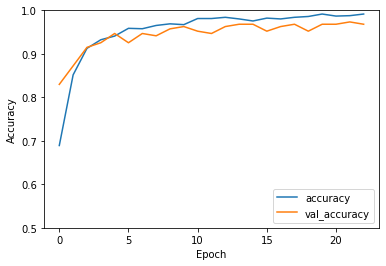

In [14]:
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

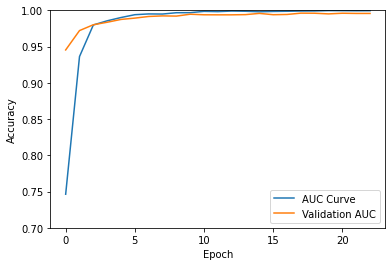

In [17]:
plt.plot(history.history['auc'], label='AUC Curve')
plt.plot(history.history['val_auc'], label = 'Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')

In [18]:
model_saved = load_model('/content/drive/MyDrive/Spotify/trained_models/spotify_CNN_keras_history.h5')

In [19]:
y_pred = model_saved.predict(test_dataset, verbose=1)


y_pred = (y_pred > 0.5).astype('int')



4/4 [==============================] - 7s 2s/step


In [29]:
loss, acc, auc = model_saved.evaluate(test_dataset)
print(acc)

4/4 [==============================] - 6s 1s/step - loss: 0.0712 - binary_accuracy: 0.9713 - auc: 0.9980
0.9713375568389893


Accuracy Score is : 97.13%
 
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       152
           1       0.99      0.95      0.97       162

    accuracy                           0.97       314
   macro avg       0.97      0.97      0.97       314
weighted avg       0.97      0.97      0.97       314

 


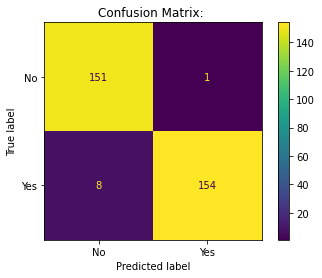

In [20]:
accuracy = accuracy_score(y_pred, y_test) 
print("Accuracy Score is : " + "{:.2%}".format(accuracy))
print(' ')
cm = confusion_matrix(y_pred, y_test, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    
disp.plot()
plt.title('Confusion Matrix: ')

print("Classification Report:")
print(classification_report(y_pred, y_test, labels=[0, 1], zero_division=1))
print(" ")
plt.show()